# Load important data

In [1]:
import os
import cv2
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Activation,BatchNormalization

# Load_Data

In [2]:
data_train = r"D:\AMIT Course\Data Set\Cats and Dogs Image\archive\train"

filepaths = []
labels = []

folds = os.listdir(data_train)

for fold in folds:
    foldpath = os.path.join(data_train, fold)
    
    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)
        
        filepaths.append(fpath)
        labels.append(fold)
        
train = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
train

,filepaths,labels
0,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
1,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
2,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
3,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
4,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
...,...,...
552,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs
553,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs
554,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs
555,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs


In [3]:
data_test = r"D:\AMIT Course\Data Set\Cats and Dogs Image\archive\test"

filepaths = []
labels = []

folds = os.listdir(data_test)

for fold in folds:
    foldpath = os.path.join(data_test, fold)
    
    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)
        
        filepaths.append(fpath)
        labels.append(fold)
        
test_df = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
test_df

,filepaths,labels
0,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
1,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
2,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
3,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
4,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,cats
...,...,...
135,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs
136,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs
137,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs
138,D:\AMIT Course\Data Set\Cats and Dogs Image\ar...,dogs


In [4]:
train_df ,valid_df = train_test_split(train, test_size=0.5, random_state=42,shuffle=True)

# Data Augmentation 

In [5]:
# Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=0.45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    #validation_split=0.2
)

def preprocess_image(image):
    return image.astype('float32') / 255. 
    
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
    #subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
    #subset='training'
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
    #subset='training'
)

Found 278 validated image filenames belonging to 2 classes.
Found 279 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.


# Add Transfer Learning

In [6]:
base_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling="max",
    classes=1000,
    classifier_activation="softmax",
    name="inception_resnet_v2",)
base_model.trainable = False

In [7]:
# base_model = MobileNetV2(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(224, 224, 3),
#     pooling="max",
#     classes=1000,
#     classifier_activation="softmax",
#     name="inception_resnet_v2",)
# base_model.trainable = False

In [8]:
# base_model = VGG16(
#      include_top=False,
#      weights="imagenet",
#      input_tensor=None,
#      input_shape=(224, 224, 3),
#      pooling=max,
#      classes=1000,
#      classifier_activation="softmax",
#      name="inception_resnet_v2",)

# base_model.trainable = False

# CNN

In [9]:
model = Sequential([
    base_model, 
    # Conv2D(64, (3, 3), activation='relu'),
    # MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
   # Dropout(0.2),
    Dense(2, activation='softmax')  
])

model.compile(optimizer=Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 1536)           │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,298,306 (210.95 MB)

 Trainable params: 961,570 (3.67 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

# Early stopping if validation loss doesn't improve for 3 epochs

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=4,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

# Save the best model during training

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Use .keras extension
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Save only the best model
    mode='max'                    # Maximize the monitored metric
)

# Reduce learning rate if validation loss plateaus

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Reduce learning rate by a factor of 0.1
    patience=3           # Number of epochs to wait before reducing LR
)


# Add callbacks to model.fit()

In [13]:
# Add callbacks to model.fit()
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Add callbacks here
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 101s 8s/step - accuracy: 0.5419 - loss: 0.8414 - val_accuracy: 0.8244 - val_loss: 0.4370 - learning_rate: 1.0000e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.8106 - loss: 0.4360 - val_accuracy: 0.8530 - val_loss: 0.3651 - learning_rate: 1.0000e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.7981 - loss: 0.4354 - val_accuracy: 0.8746 - val_loss: 0.3474 - learning_rate: 1.0000e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.8889 - loss: 0.3281 - val_accuracy: 0.8674 - val_loss: 0.3365 - learning_rate: 1.0000e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.8758 - loss: 0.3216 - val_accuracy: 0.8746 - val_loss: 0.3090 - learning_rate: 1.0000e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.9083 - loss: 0.2522 - val_accuracy: 0.8889 - val_loss: 0.2925 - learning_rate: 1.0000e-04
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.8880 - loss: 0.2714 - val

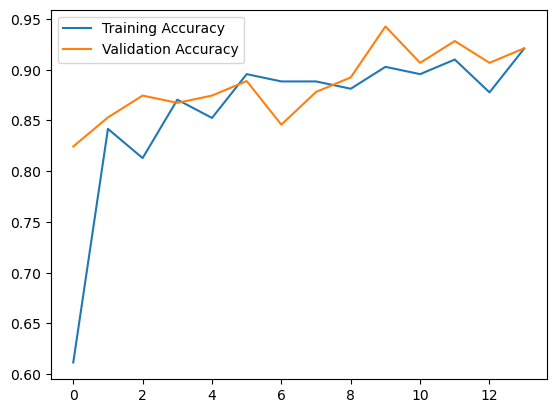

Model training completed!


In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

print("Model training completed!")

# Evaluate 

In [15]:
train_score = model.evaluate(train_generator)
valid_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ",test_score[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9233 - loss: 0.2321
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9197 - loss: 0.2378
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8816 - loss: 0.2875
Train Loss:  0.22676785290241241
Train Accuracy:  0.935251772403717
--------------------
Validation Loss:  0.23470008373260498
Validation Accuracy:  0.9068100452423096
--------------------
Test Loss:  0.3210654556751251
Test Accuracy:  0.8714285492897034


# Show

5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step


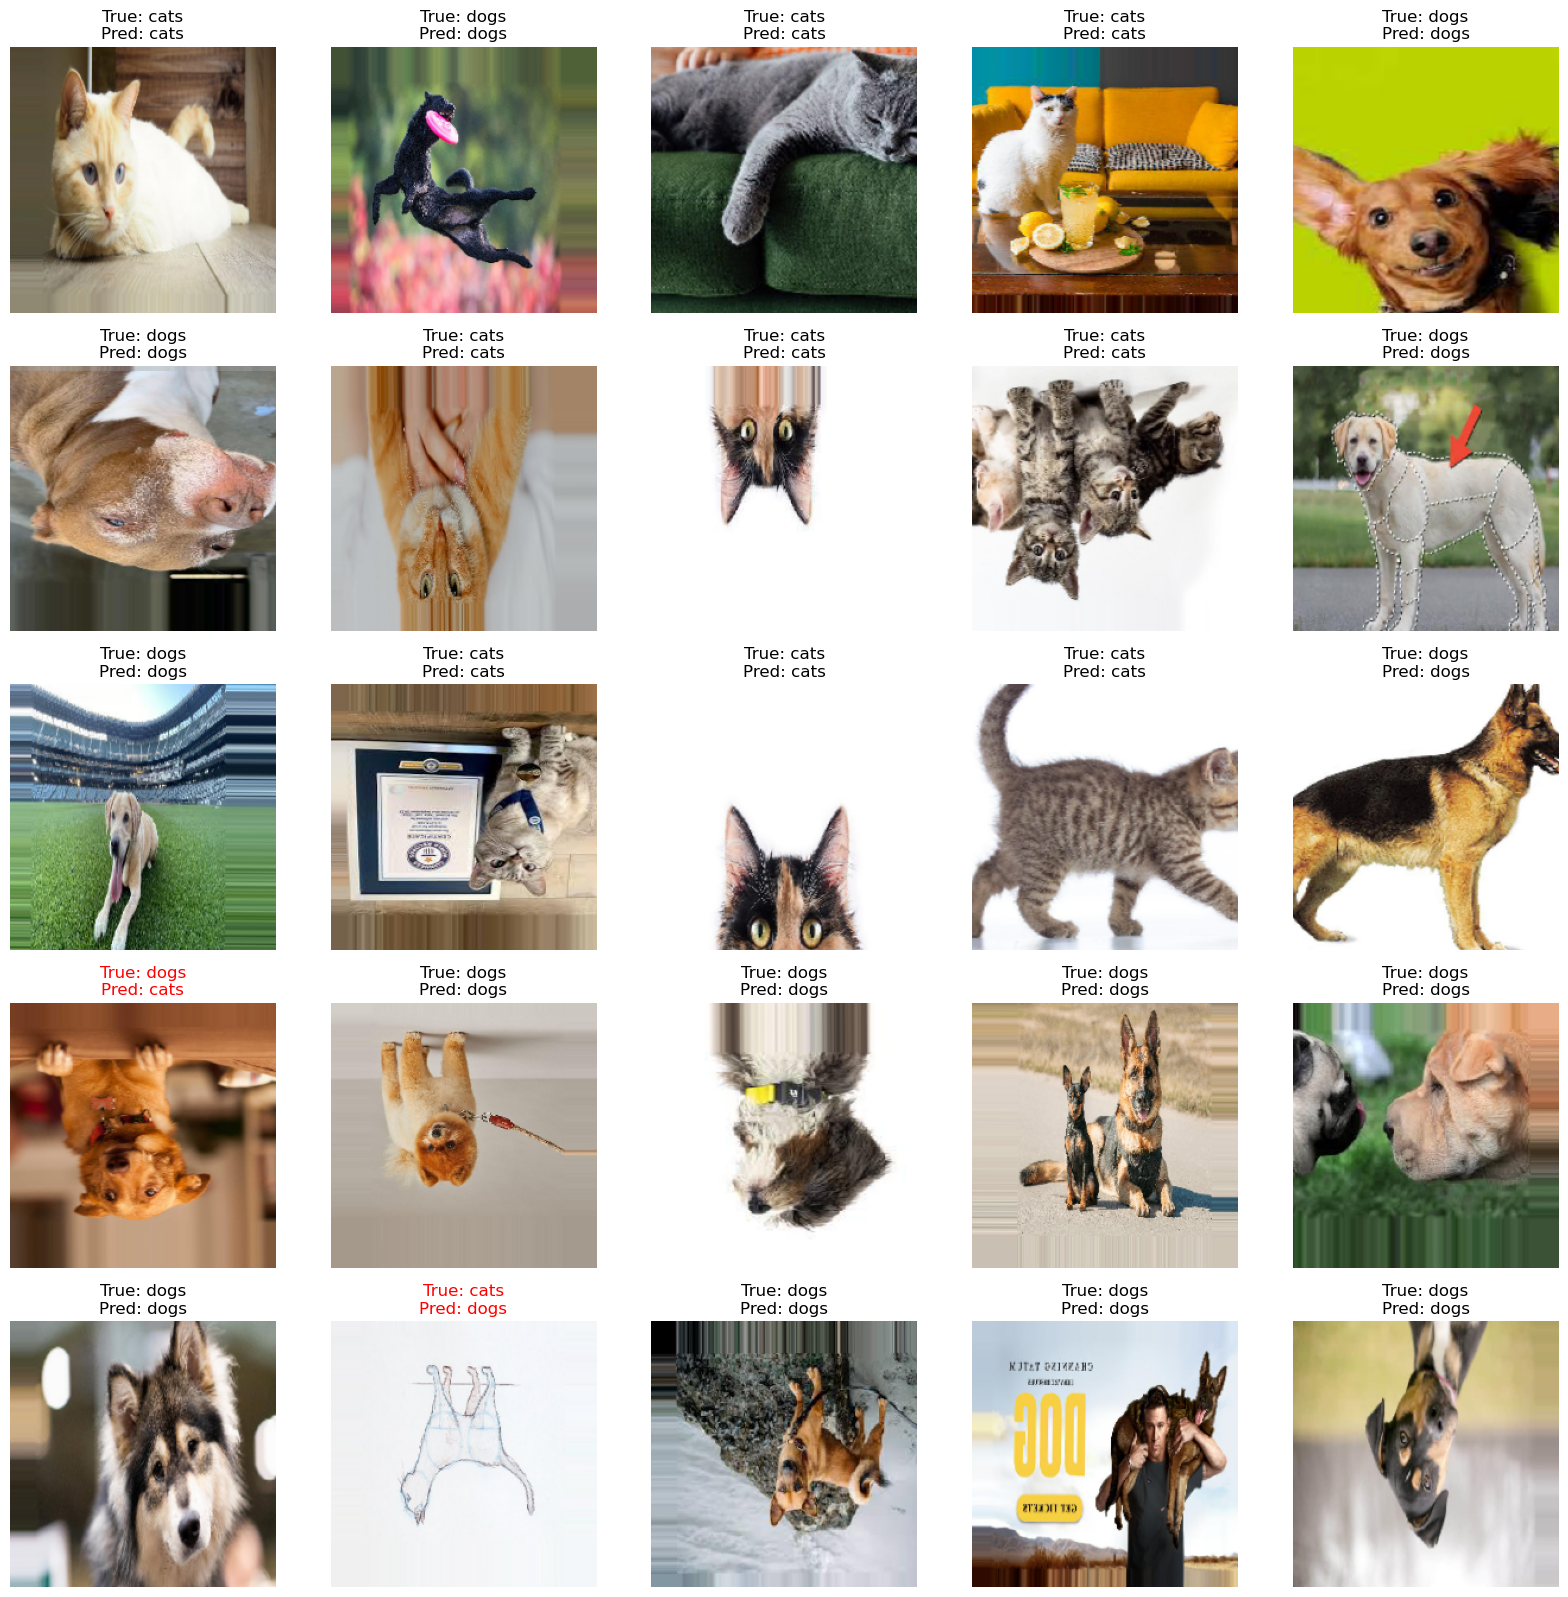

In [16]:
images, labels = test_generator[0]    
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)     
true_classes = np.argmax(labels, axis=1)   
class_labels = list(test_generator.class_indices.keys())  # ['Cat', 'Dog']
def plot_images(images, true_labels, predicted_labels, class_labels):
    plt.figure(figsize=(20, 20))
    for i in range(25):  
        plt.subplot(5, 5, i + 1)
        plt.imshow((images[i] * 255).astype(np.uint8))  
        plt.axis('off')
        true_label = class_labels[true_labels[i]]
        predicted_label = class_labels[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}",
                  color="black" if true_label == predicted_label else "red") 
    plt.show()
plot_images(images, true_classes, predicted_classes[:len(images)], class_labels)

# description 

# Cats vs. Dogs Image Classifier using InceptionResNetV2
#### This project implements a deep learning pipeline to classify images of cats and dogs using Transfer Learning with the InceptionResNetV2 architecture. It includes preprocessing, data augmentation, training, evaluation, and visualization stages, offering high accuracy on both validation and test sets.

## Project Overview
#### This image classification model is trained on a balanced dataset of cat and dog images. The implementation uses TensorFlow and Keras, applying a transfer learning strategy by leveraging a pre-trained InceptionResNetV2 model (with frozen convolutional layers) followed by a custom fully connected classification head.

## Key Features
###  Custom dataset loading from local directory structure

###  Advanced data augmentation using ImageDataGenerator

###  Transfer Learning with InceptionResNetV2 (ImageNet weights)

###   Categorical classification with softmax output (Cat vs. Dog)

###   Real-time training metrics visualization using Matplotlib

###   Model evaluation with classification report and confusion matrix

###   Modular and reproducible training pipeline

## Technologies & Libraries
#### Python 3.x

#### TensorFlow / Keras

#### OpenCV

#### NumPy / Pandas

#### Scikit-learn

#### Matplotlib

## Model Performance
#### Train Accuracy: 93.5%

#### Validation Accuracy: 90.7%

#### Test Accuracy: 87.1%

#### Note: The model uses EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau callbacks to ensure optimal convergence and avoid overfitting.

## Visual Output
#### The project includes functions to:

#### Display training and validation accuracy/loss curves

#### Show sample predictions (with correct/incorrect labels highlighted)

#### Generate a confusion matrix for test predictions

## Dataset Structure
#### Organized in folders as follows:

#### bash
#### Copy
#### Edit
#### train/
####   ├── Cat/
####   └── Dog/
#### test/
####   ├── Cat/
####   └── Dog/
## How to Run
#### Clone the repository.

#### Update dataset paths as needed.

#### Install dependencies: pip install -r requirements.txt

#### Run the notebook or Python script to train the model.

## Future Improvements
#### Add support for real-time webcam predictions.

#### Experiment with fine-tuning the base model.

#### Deploy as a web application with TensorFlow.js or Flask.